In [1]:
import math
import pandas as pd 
import datetime as datetime
import numpy as np
from math import *
from nose.result import ln
import statistics
import matplotlib as plt


z= pd.read_csv('HistoricalPrices.csv')
z['Date'] = pd.to_datetime(z['Date'])
#https://sdw.ecb.europa.eu/browseTable.do?org.apache.struts.taglib.html.TOKEN=cc2a95144d1e6553ab602818d7d2f012&df=true&MAX_DOWNLOAD_SERIES=500&DATASET=0&DATASET=1&DATASET=2&DATASET=3&org.apache.struts.taglib.html.TOKEN=276809922bea52cc04f3bc99bdf7acfa&legendRef=reference&node=9691417&SERIES_MAX_NUM=50&SERIES_KEY=165.YC.B.U2.EUR.4F.G_N_A.SV_C_YM.SR_2Y&legendPub=published&activeTab=YC&start=01-01-2014&end=20-02-2021&submitOptions.x=0&submitOptions.y=0&trans=N&q=&type=

#volatility measured asfunction of lognormally distributed daily price changes from 2014 / 2017
Sclose_2014_2017 = z.loc[z['Date']<='29-12-2017',[' Close']]
Sclose_list = Sclose_2014_2017[' Close'].tolist() 

### Sigma

La sigma se mantiene constante a lo largo de todas las simulaciones. la calculamos aquí y mantenemos el valor para todo el año.

In [2]:
def compute_sigma(close_prices):

    lr = []

    for a in range(len(close_prices)-1):
        sx = close_prices[a+1]
        sy = close_prices[a] 
        lr.append(np.log(sx/sy))

    return np.sqrt(len(close_prices))*np.std(lr)

In [3]:
sigma = compute_sigma(Sclose_list)

### Risk-free rate

Este valor se mantiene constante también a lo largo de todas las simulaciones.

In [5]:
#13mos of study risk-free rate
a = pd.read_csv('data.csv', skiprows=4)
a.columns = ['Date','rfr']
a['Date'] = pd.to_datetime(a['Date'])
a.dtypes
rfr_18 = a.loc[(a['Date']>= '01-12-2017') & (a['Date']<='28-12-2018'), ['rfr']]
rfr = rfr_18['rfr'].to_numpy()
#avg risk free rate for 13mos 01-12-2017 / 28-12-2018
rf = ((sum(rfr)/len(rfr)))/100

In [7]:
#13mos of study risk-free rate
#b = pd.read_csv('risk-free-rate.csv', skiprows=4)
#b.columns = ['Date','rfr']
#b['Date'] = pd.to_datetime(b['Date'])
#rfr = b['rfr'].to_numpy()
#avg risk free rate for 13mos 01-12-2017 / 28-12-2018
#rf = ((sum(rfr)/len(rfr)))/100

#### TODO: Hay que ajustar los valores para que tanto el dt, como la sigma y el rf estén en a misma medida.

In [7]:
#non-paying dividends
dy = 0 

#dt 1yr = 365
dt = 1/(365) 

### Parameters rescaling

rrf - from 3yrs to 1yr

In [8]:
type(rf)
rfr1 = np.log((1+rf)**3)
print(rf)
print(rfr1)

-0.006636913760000002
-0.019977108026287365


sigma

In [10]:
sigma = sigma*np.sqrt(3)

Para el primer día cogemos directamente como $S_0$ el closing price del 29-12-2017

In [11]:
#So at 29-12-2017
so = z.loc[z['Date'] == '29-12-2017',' Close'].values[0]

### Monte Carlo simulation

In [12]:
#montecarlo simulation
def monte_carlo(s0, sigma, dt, dy):
    #normal w/ 10,000 iterations
    Zt = np.random.normal(0,1,10000)
    x1 = sigma*Zt*np.sqrt(dt)

    #return s0*np.exp((np.log(1+rf) - (np.square(sigma))/2 - np.log(1+dy))*dt + x1)
    return s0*np.exp((rfr1 - (np.square(sigma))/2 - np.log(1+dy))*dt + x1)

In [13]:
monte_carlo(so, sigma, dt, dy)

array([174.37083936, 189.72820118, 191.47615309, ..., 175.07274375,
       197.17095126, 185.14141718])

### Full GBM

Usamos el mismo modelo anterior y lo vamos exportando para todos los días. En cada caso cogemos la sigma predicha en el timestep anterior como $S_0$.

#### TODO: definir el dt día día es vez de usar siempre un único valor

In [14]:
#bsm model
# max_iter es el número total de iteraciones (1 año)
def bsm(s0, sigma, dt,  dy, max_iter=365):
    results = np.empty(shape=(max_iter, 10000))
    for t in range(max_iter):
        # el output pasa a ser el input
        s0 = monte_carlo(s0, sigma, dt, dy)
        results[t] = s0
    return results

In [15]:
x = bsm(so, sigma, dt, dy)
print(x)


[[180.66793332 190.85444979 184.04659598 ... 186.03301426 174.46387038
  178.39330519]
 [192.79639763 179.73246438 175.4431563  ... 190.17372388 184.24789214
  182.60951594]
 [187.08959046 190.43781992 183.3556162  ... 186.47600132 189.50896763
  183.89536218]
 ...
 [ 41.54336002 265.26760328  50.14672951 ... 101.85763032  95.14679196
   98.33684427]
 [ 40.33777256 278.04106973  48.65909527 ... 102.50588782  88.73378577
   99.93472175]
 [ 40.48327689 273.86344778  51.18559413 ...  95.4635627   90.18918972
   98.1870021 ]]


### Validation

#### Plot of the last day 10,000 simulated values, if the distribbution is lognormal it will be assumed that each day's values also follow the same distribution

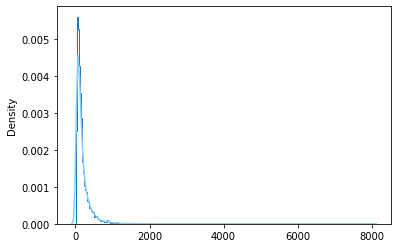

In [32]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns 

b = plt.hist(x[-1], density = True, bins = 300, facecolor="darkblue", histtype = 'step')
sns.kdeplot(x[-1], color='lightskyblue')
plt.show()

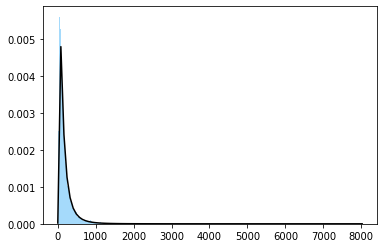

In [19]:
s, loc, scale = stats.lognorm.fit(x[-1], floc=0)
µ_est = np.log(scale)
sigma_est = s
plt.hist(x[-1], bins=300, density=True, color='lightskyblue', alpha=0.75)
amin = x[-1].min()
amax = x[-1].max()
a = np.linspace(amin, amax, 100)
pdf = stats.lognorm.pdf(a, s, scale=scale)
plt.plot(a, pdf, 'k')

#### Plot returns to check for a normal distribution

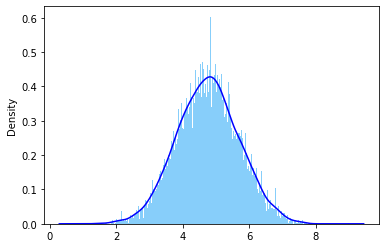

In [22]:
b = plt.hist(np.log(x[-1]), density = True, bins = 300, facecolor="lightskyblue")
sns.kdeplot(np.log(x[-1]), color='b')
plt.show()

#### Q-Q Plot


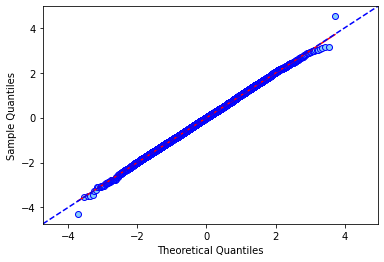

In [26]:
import statsmodels.api as sm

a = sm.qqplot(np.log(x[-1]), line = 'q', fit = True, markerfacecolor='lightskyblue', markeredgecolor='b')
sm.qqline(a.axes[0], line='45', fmt='b--')



#### Jarque Bera Test

 - Ho: Normal Distribution
 - Ha: Non-Normal Distribution

Chi-squared Distribution w/ df = 2

In [21]:
stats.jarque_bera(np.log(x[-1]))

Jarque_beraResult(statistic=0.013220127334861569, pvalue=0.9934117347473316)

#### Daily result check

In [28]:
avg_prices,st_dev,e_avg_prices,e_st_dev,e_rel_avg,e_rel_std = ([] for i in range(6))
d = {}
for a in x:
    avg_prices.append(np.mean(a))
    st_dev.append(np.std(a))

d['avg_prices'] = avg_prices
d['st_dev'] = st_dev
so = z.loc[z['Date'] == '29-12-2017',' Close'].values[0]
µ = rfr1
e_avg_prices=[so*(exp(µ)**(y/365)) for y in range(1,366)]
e_st_dev=[(e_avg_prices[y-1]*np.sqrt((exp((sigma**2)*((y)/365)))-1)) for y in range(1,366)]
e_rel_avg=[(((avg_prices[y-1]/e_avg_prices[y-1])-1)*100) for y in range(1,366)]
e_rel_std=[(((st_dev[y-1]/e_st_dev[y-1])-1)*100) for y in range(1,366)]
d['e_avg_prices'] = e_avg_prices
d['e_st_dev'] = e_st_dev
d['e_rel_avg'] = e_rel_avg
d['e_rel_std'] = e_rel_std
columns_names = ['Avg','Sd','E(avg)', 'E(Sd)', '%rel_error_avg','%rel_error_sd']
daily_check = pd.DataFrame(d)
daily_check.columns = columns_names
daily_check
year_simulation = '2018'
i = pd.date_range(start = pd.Timestamp(year_simulation),end = pd.Timestamp(year_simulation) + pd.offsets.YearEnd(0),freq = 'D')
i_list = []
for a in i:
    i_list.append(datetime.datetime.strftime(a,'%Y-%m-%d'))
daily_check.index = i_list
print(daily_check)
table_daily_check = daily_check.to_excel('\daily_check.xlsx')

                   Avg          Sd      E(avg)       E(Sd)  %rel_error_avg  \
2018-01-01  183.984471    9.018094  183.979930    9.014652        0.002468   
2018-01-02  183.877766   12.686500  183.969861   12.755594       -0.050060   
2018-01-03  183.845190   15.618671  183.959792   15.630870       -0.062297   
2018-01-04  183.818049   18.097050  183.949724   18.058824       -0.071582   
2018-01-05  183.850473   20.235179  183.939656   20.201403       -0.048485   
...                ...         ...         ...         ...             ...   
2018-12-27  179.801860  212.700164  180.390370  211.646060       -0.326242   
2018-12-28  179.798067  211.574569  180.380498  212.072622       -0.322890   
2018-12-29  179.858830  213.825457  180.370625  212.499282       -0.283747   
2018-12-30  179.970393  215.347668  180.360754  212.926041       -0.216433   
2018-12-31  179.835438  214.883477  180.350882  213.352902       -0.285801   

            %rel_error_sd  
2018-01-01       0.038183  
2018-01

#### Plot residual errors to check for randomness

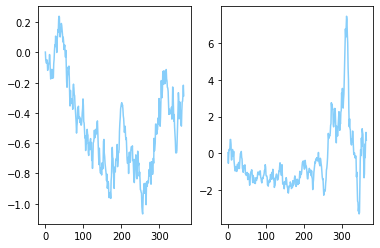

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(e_rel_avg, color = 'lightskyblue')
ax2.plot(e_rel_std, color = 'lightskyblue')